### 对2018年AMD期货数据收集与处理

In [1]:
import pandas as pd
import numpy as np

In [2]:
path_C_ob = 'real_2018_AMD_sample/C_ob.csv'
path_LIBOR = 'real_2018_AMD_sample/LIBOR USD2.csv'
path_X = 'real_2018_AMD_sample/strike_price.csv'

In [3]:
C_obs_file = pd.read_csv(path_C_ob)
# 调整date格式, 删除ticker和close
C_obs_file['date'] = pd.to_datetime(C_obs_file['date'])
C_obs_file = C_obs_file.drop(['ticker', 'open'], axis=1)
C_obs_file.head()

,date,close
0,2018-06-19,16.69
1,2018-06-20,16.52
2,2018-06-21,15.65
3,2018-06-22,15.80
4,2018-06-25,15.11


In [4]:
LIBOR_file = pd.read_csv(path_LIBOR)
# 调整date格式, 保留date和1M
LIBOR_file['Date'] = pd.to_datetime(LIBOR_file['Date'])
LIBOR_file = LIBOR_file[['Date', '1M']]
# Date改为date, 1M改为r
r = LIBOR_file.rename(columns={'Date': 'date', '1M': 'r'})
r.head()

,date,r
0,2024-08-09,5.44800
1,2024-08-08,5.44114
2,2024-08-07,5.43949
3,2024-08-06,5.40400
4,2024-08-05,5.44188


In [5]:
strick_price_file = pd.read_csv(path_X)
# 调整date格式, 保留date, exdate, strike_price_processed
strick_price_file['date'] = pd.to_datetime(strick_price_file['date'])
# print(strick_price_file.columns)
strick_price = strick_price_file[['date', 'exdate', 'strike_price_processed', 'best_bid', 'best_offer']]
strick_price.head()

,date,exdate,strike_price_processed,best_bid,best_offer
0,2018-06-19,2018/7/20,10.0,6.65,6.75
1,2018-06-19,2018/7/20,10.5,6.15,6.25
2,2018-06-19,2018/7/20,11.0,5.70,5.75
3,2018-06-19,2018/7/20,11.5,5.20,5.30
4,2018-06-19,2018/7/20,12.0,4.70,4.80


In [6]:
# 查看 r 的日期范围
print(r['date'].min())
print(r['date'].max())
# 查看 strick_price 的日期范围
print(strick_price['date'].min())
print(strick_price['date'].max())
# 查看 C_obs 的日期范围
print(C_obs_file['date'].min())
print(C_obs_file['date'].max())

1986-01-02 00:00:00
2024-08-09 00:00:00
2018-06-19 00:00:00
2018-07-20 00:00:00
2018-06-19 00:00:00
2018-08-24 00:00:00


In [7]:
# 筛选出2018-06-19到2018-07-20的数据
r = r[(r['date'] >= '2018-06-19') & (r['date'] <= '2018-07-20')]
strick_price = strick_price[(strick_price['date'] >= '2018-06-19') & (strick_price['date'] <= '2018-07-20')]
C_obs_file = C_obs_file[(C_obs_file['date'] >= '2018-06-19') & (C_obs_file['date'] <= '2018-07-20')]
r.head(), strick_price.head(), C_obs_file.head()

(           date        r
 1529 2018-07-20  2.06900
 1530 2018-07-19  2.08100
 1531 2018-07-18  2.08625
 1532 2018-07-17  2.08175
 1533 2018-07-16  2.07850,
         date     exdate  strike_price_processed  best_bid  best_offer
 0 2018-06-19  2018/7/20                    10.0      6.65        6.75
 1 2018-06-19  2018/7/20                    10.5      6.15        6.25
 2 2018-06-19  2018/7/20                    11.0      5.70        5.75
 3 2018-06-19  2018/7/20                    11.5      5.20        5.30
 4 2018-06-19  2018/7/20                    12.0      4.70        4.80,
         date  close
 0 2018-06-19  16.69
 1 2018-06-20  16.52
 2 2018-06-21  15.65
 3 2018-06-22  15.80
 4 2018-06-25  15.11)

In [8]:
# 定义data，按日期合并三个dataframe
data = pd.merge(r, strick_price, on='date', how='inner')
data = pd.merge(data, C_obs_file, on='date', how='inner')
# 删除close
data.head()

,date,r,exdate,strike_price_processed,best_bid,best_offer,close
0,2018-07-20,2.069,2018/8/24,10.0,6.45,6.60,16.5
1,2018-07-20,2.069,2018/8/24,10.5,5.95,6.10,16.5
2,2018-07-20,2.069,2018/8/24,11.0,5.45,5.70,16.5
3,2018-07-20,2.069,2018/8/24,11.5,4.95,5.20,16.5
4,2018-07-20,2.069,2018/8/24,12.0,4.55,4.65,16.5


In [9]:
# 将close重命名为option_price(C), 1M重命名为r, strike_price_processed重命名为strick_price(X)
data = data.rename(columns={'best_bid': 'option_price(C_bid)', 'best_offer': 'option_price(C_offer)', 'strike_price_processed': 'strick_price(X)'})
# 将exdate的日期格式转换为 %Y-%m-%d
data['exdate'] = pd.to_datetime(data['exdate'])
# 创建新的列，计算tau(T/365)，tau = (exdate - date) / 365
data['tau(T/365)'] = (data['exdate'] - data['date']).dt.days / 365
data.head()

,date,r,exdate,strick_price(X),option_price(C_bid),option_price(C_offer),close,tau(T/365)
0,2018-07-20,2.069,2018-08-24,10.0,6.45,6.60,16.5,0.09589
1,2018-07-20,2.069,2018-08-24,10.5,5.95,6.10,16.5,0.09589
2,2018-07-20,2.069,2018-08-24,11.0,5.45,5.70,16.5,0.09589
3,2018-07-20,2.069,2018-08-24,11.5,4.95,5.20,16.5,0.09589
4,2018-07-20,2.069,2018-08-24,12.0,4.55,4.65,16.5,0.09589


In [10]:
# 保存到文件
data.to_csv('real_2018_6_7_AMD_data.csv', index=False)

### 数据清洗与检验

In [11]:
# 读取文件
data = pd.read_csv('real_2018_6_7_AMD_data.csv')
C_obs = data['option_price(C_bid)']
r = data['r']
X = data['strick_price(X)']
T = data['tau(T/365)']

Text(0.5, 1.0, 'C_obs and X')

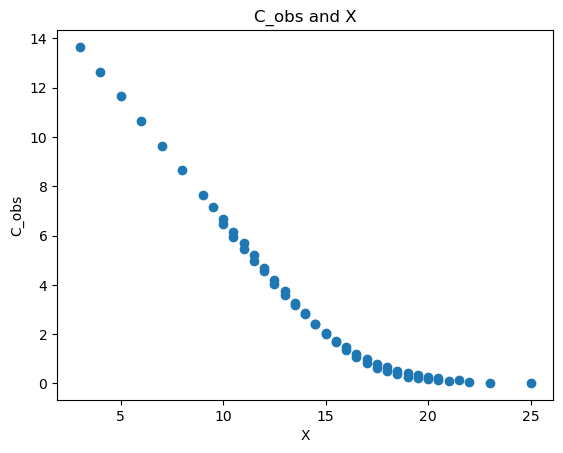

In [12]:
# 绘制C_obs和X的散点图
import matplotlib.pyplot as plt
plt.scatter(X, C_obs)
plt.xlabel('X')
plt.ylabel('C_obs')
plt.title('C_obs and X')